In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import diags
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 14})

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,Nx)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

def normalize(inn):
    return inn/(sum(inn)*dx)

In [2]:
amplitude = 1
vmin = 0                                        #Min velocity
vmax = 1                                        #Max velocity
pxtomum=0.0533#e-6                               #px to µm [µm/px]
sigma = 50*pxtomum                                     #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14*1e12                                  #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200
vdiff = vmax - vmin
vactive = 6

videosize = 800    
programtime = 3                            #time of the program (tracking + calculation) [s]
iterationtime = 51.9986
delayincrease = 4
addtime = videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2

taur = 0.65#1
Nx = 200                     #x steps
Nt = 1000                    #t steps
L = 2*boundaryradius                       #Length of the domain ([0,L])
T = 5                        #Stop time of the simulation
#Remark T should be smaller Nt/200 to get resonable 
#results for the explicit method
start = int(Nx/2)

x = np.linspace(-boundaryradius, boundaryradius, Nx)    #x space   
t = np.linspace(0, T, Nt)    #t space
dt = t[1]-t[0]               #t step
dx = x[1] - x[0]             #x step
F = dt**2/dx**2
sigmaterm = sigma**2

In [3]:
Ntest = 50
tlength = 5
delaytime = np.zeros(tlength)
for i in range(tlength):
    delay = 1 + 4*i
    delaytime[i] = iterationtime*1e-3*(delay-1)+dt/2+addtime 
    
#ttest = np.arange(0.05, 2.1, 0.05*4)
savev = np.zeros((Ntest,tlength,6))
for k in range(tlength):
    delay = 1+delayincrease*k
    t = iterationtime*1e-3*(delay-1)+dt/2+addtime 
    #t = ttest[k]
    startpoints = np.zeros((Ntest,3))
    startpoints[:,0] = np.linspace(0,boundaryradius,Ntest)
    for i in range(Ntest):                  #Calculate how fast it travels depending on the start position
        I = amplitude*np.exp(-startpoints[i,0]**2/sigmaterm)
        startpoints[i,1] = vactive*vdiff*np.exp(-I/amplitude)+vmin
        startpoints[i,2] = startpoints[i,1]*t*(1-t/taur)

    circlesteps = 360
    circlearray = np.zeros((circlesteps,Ntest,4))

    for i in range(Ntest):
        for j in range(circlesteps):
            circlearray[j,i,2] = 360/circlesteps*j     #Calculate final position depending on position and angle
            circlearray[j,i,0] = startpoints[i,0] + startpoints[i,2] * np.sin(circlearray[j,i,2]*np.pi/180)
            circlearray[j,i,1] = startpoints[i,2] * np.cos(circlearray[j,i,2]*np.pi/180)
            dist = np.sqrt(pow(circlearray[j,i,0],2)+pow(circlearray[j,i,1],2))
            I = amplitude*np.exp(-dist**2/sigmaterm)
            circlearray[j,i,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin

    calculatev = np.zeros((Ntest,5))           #Average v for every position and in and out
    calculatev[:,0] = startpoints[:,0]
    for i in range(Ntest):
        calculatev[i,1] = np.mean(circlearray[:,i,3])
        calculatev[i,2] = np.mean(circlearray[:int(circlesteps/2),i,3])
        calculatev[i,3] = np.mean(circlearray[int(circlesteps/2):,i,3])
        calculatev[i,4] = calculatev[i,2] - calculatev[i,3]
    savev[:,k,0] = startpoints[:,0]
    savev[:,k,1] = calculatev[:,1]
    savev[:,k,2] = calculatev[:,4]
    savev[:,k,3] = calculatev[:,2]
    savev[:,k,4] = calculatev[:,3]

dx = startpoints[1,0] - startpoints[0,0]     #Normalize over integral
test = np.zeros((tlength,3))
for i in range(tlength):
    test[i,0] = sum(savev[:,i,3])*dx
    test[i,1] = sum(savev[:,i,4])*dx
test[:,2] = test[:,0] + test[:,1]
test[:,0] /= test[:,2]
test[:,1] /= test[:,2]

for k in range(tlength):
    savev[:,k,5] = (savev[:,k,3]*test[k,0] + savev[:,k,4]*test[k,1])

<ipython-input-48-ba33988c1e0b>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(x,y,field[:,:,3])


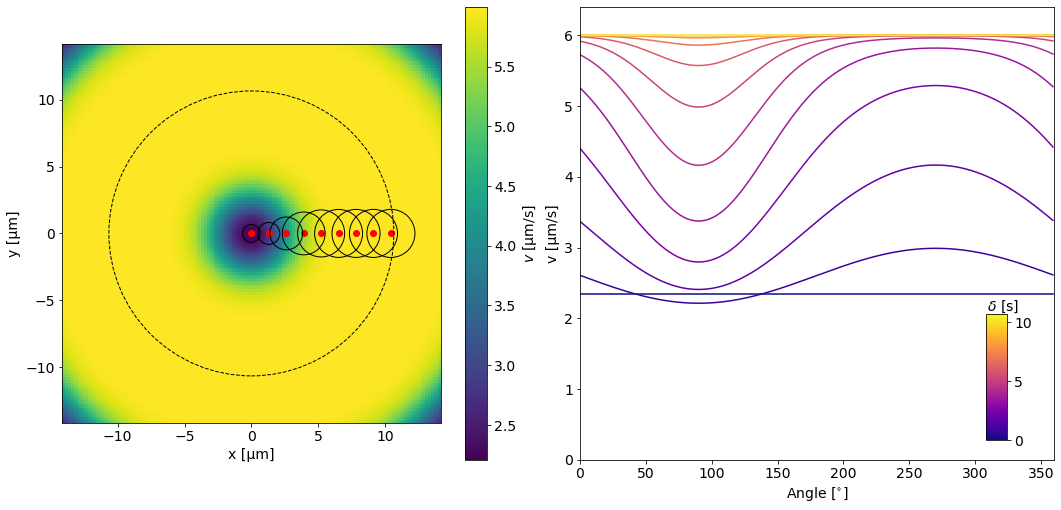

In [48]:
Nx = 201                     #x steps
steps = boundaryradius*4/Nx
field = np.zeros((Nx,Nx,4))

for i in range(Nx):          #Create v field - just for drawing
    field[:,i,0] = np.linspace(-2*boundaryradius,2*boundaryradius,Nx)
    field[i,:,1] = np.linspace(-2*boundaryradius,2*boundaryradius,Nx)
for i in range(Nx):
    for j in range(Nx):
        field[i,j,2] = np.sqrt(pow(field[i,j,0],2)+pow(field[i,j,1],2))
        if field[i,j,2] <= boundaryradius:
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin
        else: 
            field[i,j,2] = 2*boundaryradius - field[i,j,2] 
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin

fig=plt.figure(1, figsize = (15,7) )
ax = plt.subplot(1,2,1)
ax.set_aspect('equal')
factor = 2
y, x = np.mgrid[slice(-factor*boundaryradius, factor*boundaryradius, steps),
                slice(-factor*boundaryradius, factor*boundaryradius, steps)]
im = ax.pcolor(x,y,field[:,:,3])
value = 1.5*boundaryradius+startpoints[-1,2]
ax.set_xlim(-value,value)
ax.set_ylim(-value,value)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

colorwave = cm.plasma(np.linspace(0, 1, Ntest))
circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax.add_artist(circle2)
for i in range(Ntest):
    if i % 6 == 0:
        plt.scatter(startpoints[i,0], 0,color='r')
        circle3 = plt.Circle((startpoints[i,0], 0), startpoints[i,2], color='k', fill=False)
        ax.add_artist(circle3)
cb = fig.colorbar(im, ax=ax)
cb.set_label(r'$v$ [µm/s]')

ax2 = plt.subplot(1,2,2)
for i in range(Ntest):
    if i % 4 == 0:
        ax2.plot(circlearray[:,i,3],color=colorwave[i])
plt.xlim([0,360])
plt.ylim([0,6.4])

plt.tight_layout()  
data = np.linspace(startpoints[0,0], startpoints[-1,0], Ntest).reshape(Ntest, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax2)
cax = fig.add_axes([0.92, 0.11, 0.02, 0.25])
plt.colorbar(im, cax=cax)
plt.text(0.8,11,r'$\delta$ [s]')
ax2.set_xlabel(r'Angle [$^{\circ}$]')
ax2.set_ylabel('v [µm/s]')

plt.savefig('Fig1.pdf', format='pdf')
plt.show()

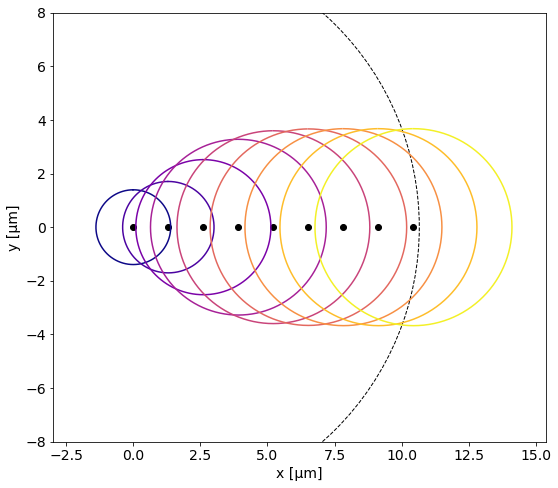

In [4]:
colorwave = cm.plasma(np.linspace(0, 1, Ntest))

fig=plt.figure(1, figsize = (9,7) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
value = 1.1*boundaryradius+startpoints[-1,2]
ax.set_xlim(-3,value)
ax.set_ylim(-8,8)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax.add_artist(circle2)
for i in range(Ntest):
    if i % 6 == 0:
        plt.scatter(startpoints[i,0],0,color='k')
        plt.plot(circlearray[:,i,0],circlearray[:,i,1],c=colorwave[i])
        
plt.tight_layout() 
plt.savefig('Circles.pdf', format='pdf')
plt.savefig('Circles.svg', format='svg')
plt.show()

In [5]:
dt = 0.05
savealltimes = np.zeros((tlength,2))
for k in range(tlength):                  #Calculate normalization for travel time
    savedist = [];savetime = []
    check = True; distance = 0; timecount = 0
    while check == True:                       #Move outwards
        #print(round(distance,2))
        vcheck = True; i = 0
        while vcheck == True:
            #print(round(distance,2),' - ',round(savev[i,0,0],2))
            if distance <= savev[i,0,0]: 
                v = savev[i,k,4]
                vcheck = False
                #print(i,' - v = ',round(v,2))
            else: i += 1
        #print(round(v,2))
        distance += v*dt
        timecount += dt
        savedist.append(distance)
        savetime.append(timecount)
        if distance >= boundaryradius:
            check = False

    savedist2 = [];savetime2 = []
    check = True; distance = boundaryradius; timecount2 = 0
    while check == True:                       #Move inwards
        #print(round(distance,2))
        vcheck = True; i = 0
        while vcheck == True:
            #print(round(distance,2),' - ',round(savev[-i-1,0,0],2))
            if distance >= savev[-i-1,0,0]: 
                v = savev[-i-1,k,3]
                vcheck = False
                #print(i,' - v = ',round(v,2))
            else: i += 1
        #print(round(v,2))
        distance -= v*dt
        timecount2 += dt
        savedist2.append(distance)
        savetime2.append(timecount2)
        if distance <= 0:
            check = False
    savealltimes[k,0] = timecount
    savealltimes[k,1] = timecount2

ratios = np.zeros((tlength,2))
ratios[:,0] = savealltimes[:,0]/(savealltimes[:,0]+savealltimes[:,1])
ratios[:,1] = savealltimes[:,1]/(savealltimes[:,0]+savealltimes[:,1])

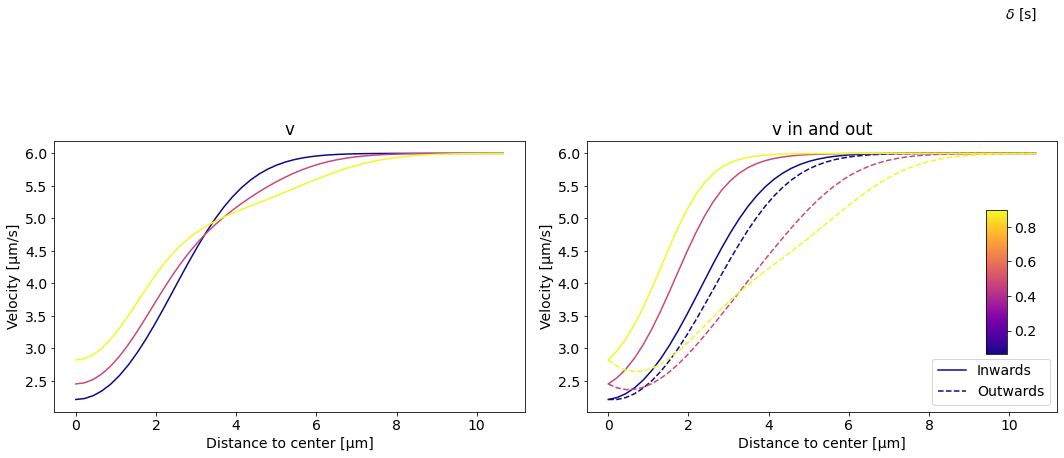

In [32]:
dx = savev[1,0,0] - savev[0,0,0]
fig=plt.figure(1, figsize = (15,5) )
ax1 = plt.subplot(1,2,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    if i % 2 == 0:
        ax1.plot(savev[:,i,0],savev[:,i,1],c=colorwave[i])
        #ax.plot(savev[:,i,0],savev[:,i,4],c=colorwave[i],linestyle='--')
    plt.title('v')
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Velocity [µm/s]')
    
ax2 = plt.subplot(1,2,2)
for i in range(tlength):
    if i == 0:
        ax2.plot(savev[:,i,0],savev[:,i,3],c=colorwave[i],label='Inwards')
        ax2.plot(savev[:,i,0],savev[:,i,4],c=colorwave[i],linestyle='--',label='Outwards')
    else:
        if i % 2 == 0:
            ax2.plot(savev[:,i,0],savev[:,i,3],c=colorwave[i])
            ax2.plot(savev[:,i,0],savev[:,i,4],c=colorwave[i],linestyle='--')
    plt.title('v in and out')
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Velocity [µm/s]')
plt.legend()

plt.tight_layout()  
data = np.linspace(delaytime[0], delaytime[-1], tlength).reshape(tlength, 1)
im = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax)
cax = fig.add_axes([0.92, 0.31, 0.02, 0.4])
plt.colorbar(im, cax=cax)
plt.text(0.8,2,r'$\delta$ [s]')

plt.savefig('Overview velocities.pdf', format='pdf')
plt.savefig('Overview velocities.svg', format='svg')
plt.show()

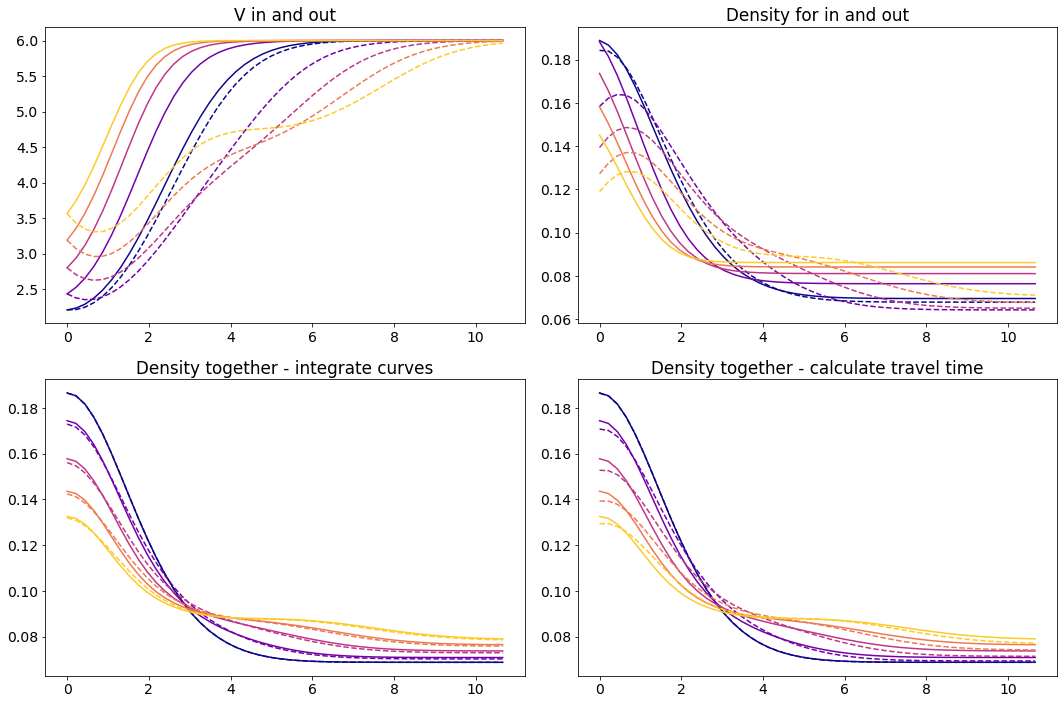

In [81]:
dx = savev[1,0,0] - savev[0,0,0]
fig=plt.figure(1, figsize = (15,10) )
ax = plt.subplot(2,2,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    if i % 2 == 0:
        ax.plot(savev[:,i,0],savev[:,i,3],c=colorwave[i])
        ax.plot(savev[:,i,0],savev[:,i,4],c=colorwave[i],linestyle='--')
    plt.title('V in and out')
    
ax2 = plt.subplot(2,2,2)
for i in range(tlength):
    if i % 2 == 0:
        ax2.plot(savev[:,i,0],normalize(1/savev[:,i,3]),c=colorwave[i])
        ax2.plot(savev[:,i,0],normalize(1/savev[:,i,4]),c=colorwave[i],linestyle='--')
    plt.title('Density for in and out')
#ax2.set_ylim([0,0.6])

ax3 = plt.subplot(2,2,3)
for i in range(tlength):
    if i % 2 == 0:
        ax3.plot(savev[:,i,0],normalize(1/savev[:,i,1]),c=colorwave[i])
        ax3.plot(savev[:,i,0],normalize(1/savev[:,i,3]*test[i,0]+1/savev[:,i,4]*test[i,1]),c=colorwave[i],linestyle='--')
    plt.title('Density together - integrate curves')
        
ax4 = plt.subplot(2,2,4)
for i in range(tlength):
    if i % 2 == 0:
        ax4.plot(savev[:,i,0],normalize(1/savev[:,i,1]),c=colorwave[i])
        ax4.plot(savev[:,i,0],normalize(1/savev[:,i,3]*ratios[i,1]+1/savev[:,i,4]*ratios[i,0]),c=colorwave[i],linestyle='--')
    plt.title('Density together - calculate travel time')
    
plt.tight_layout()  
plt.savefig('Overview.svg', format='svg')
plt.savefig('Overview.pdf', format='pdf')
plt.show()

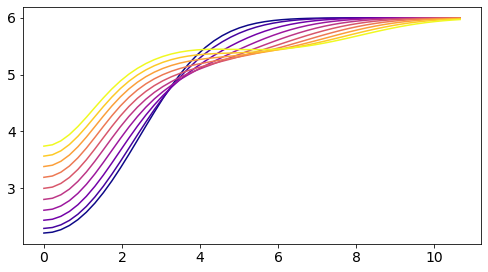

In [82]:
fig=plt.figure(1, figsize = (7,4) )
ax = plt.subplot(1,1,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savev[:,i,1],c=colorwave[i])
    #ax.plot(savev[:,i,0],savev[:,i,5],c=colorwave[i],linestyle='--')
#ax.plot(r, vtheo,color='k',linestyle='--')

plt.tight_layout()  
plt.savefig('Vprofile.svg', format='svg')
plt.savefig('Vprofile.pdf', format='pdf')
plt.show()

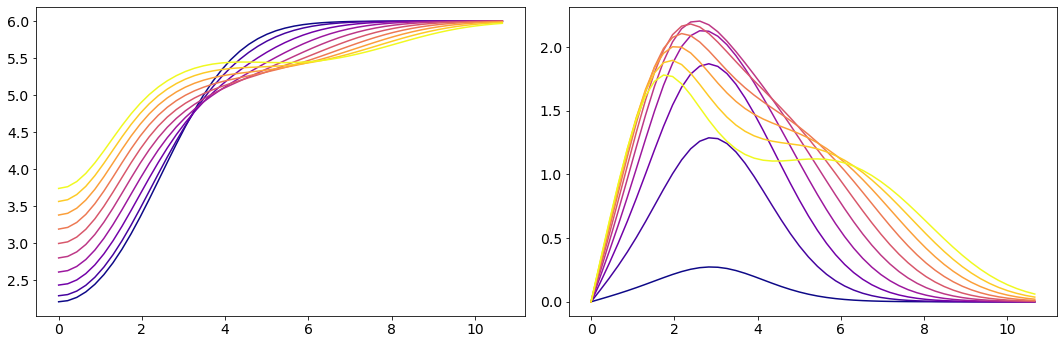

In [83]:
r, vtheo, I = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)

fig=plt.figure(1, figsize = (15,5) )
ax = plt.subplot(1,2,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savev[:,i,1],c=colorwave[i])
    #ax.plot(savev[:,i,0],savev[:,i,5],c=colorwave[i],linestyle='--')
#ax.plot(r, vtheo,color='k',linestyle='--')

ax2 = plt.subplot(1,2,2)
for i in range(tlength):
    ax2.plot(savev[:,i,0],savev[:,i,2],c=colorwave[i])
       
plt.tight_layout()  
plt.show()

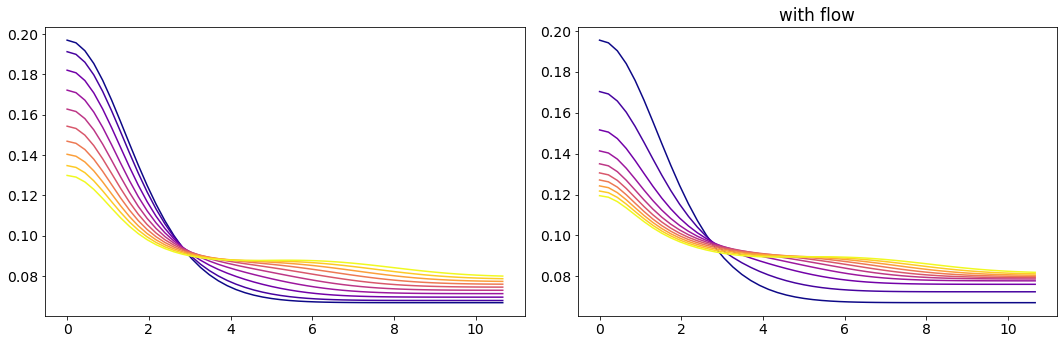

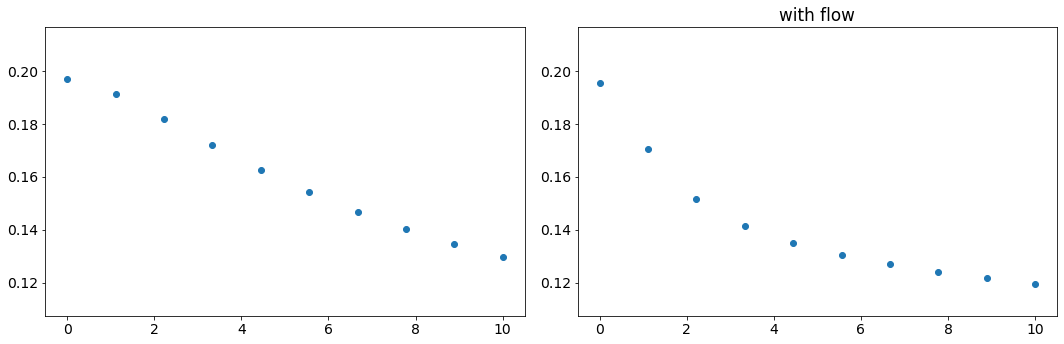

In [84]:
#dist, v, I = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
savedensity = np.zeros((Ntest,tlength))

for k in range(tlength):
    Darray = np.zeros(Ntest)
    Darray = savev[:,k,1]**2*taur/4# + D_0
    c = np.zeros(Ntest)        #array to save the density distributions
    c[0] = 1
    for i in range(0,Ntest-1):
        c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
        #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]+savev[i,k,2]**2*taur)))
        c[:] = c[:]/sum(abs(c[:])*dx)   #Normalize
    savedensity[:,k] = c

savedensity2 = np.zeros((Ntest,tlength))
for k in range(tlength):
    Darray = np.zeros(Ntest)
    Darray = savev[:,k,1]**2*taur/4# + D_0
    c = np.zeros(Ntest)        #array to save the density distributions
    c[0] = 1
    for i in range(0,Ntest-1):
        #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
        c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]+savev[i,k,2]**2*taur)))
        c[:] = c[:]/sum(abs(c[:])*dx)   #Normalize
    savedensity2[:,k] = c
    
fig=plt.figure(1, figsize = (15,5) )
ax = plt.subplot(1,2,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savedensity[:,i],c=colorwave[i])
    
ax = plt.subplot(1,2,2)
plt.title('with flow')
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savedensity2[:,i],c=colorwave[i])
    
#ax.plot(r, vtheo,color='k',linestyle='--')
plt.tight_layout()  
#plt.savefig(str(title)+'.svg', format='svg')
plt.show()

maxi = 1.1*max(savedensity[0,0],savedensity2[0,0])
mini = 0.9*min(savedensity[0,-1],savedensity2[0,-1])


fig=plt.figure(1, figsize = (15,5) )
ax = plt.subplot(1,2,1)
ax.scatter(np.linspace(0,tlength,tlength),savedensity[0,:])
ax.set_ylim([mini,maxi])
    
ax2 = plt.subplot(1,2,2)
plt.title('with flow')   
ax2.scatter(np.linspace(0,tlength,tlength),savedensity2[0,:])
ax2.set_ylim([mini,maxi])
    
plt.tight_layout()  
#plt.savefig(str(title)+'.svg', format='svg')
plt.show()

In [85]:
def calcvelocitysingle(rvalue,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    I = A*np.exp(-rvalue**2/sigmaterm)
    return vdiff*np.exp(-I/A)+vmin

def steplengththeory(t,D,V,taur):
    return np.sqrt(4*D*t+V**2*taur**2/2*(2*t/taur+np.exp(-2*t/taur)-1))

vprofilesteps = 50
rwave = np.linspace(0,boundaryradius,vprofilesteps,endpoint=True)

steps = 36
onestep = 360/steps
number = 10
maxdelay = 1+delayincrease*number
values = np.zeros(number)
for i in range(number): values[i] = 1 + delayincrease*i

everystep = np.zeros((maxdelay,vprofilesteps,steps,4))
importantsteps = np.zeros((number,vprofilesteps,steps,4))
everystep[0,:,:,0] = 0
for i in range(vprofilesteps): everystep[0,i,:,1] = rwave[i]
for i in range(steps): everystep[:,:,i,2] = onestep*i
for i in range(vprofilesteps):
    for j in range(steps):
        count = 0
        for p in range(1,maxdelay+1):
            dist = np.sqrt(pow(everystep[p-1,i,j,0],2)+pow(everystep[p-1,i,j,1],2))
            if dist >= boundaryradius:   #boundary condition - reflexion of v-profile
                dist = 2*boundaryradius - 0.5*dist
            everystep[p-1,i,j,3] = vactive*calcvelocitysingle(dist,sigma,vdiff,amplitude,vmin)
            step = steplengththeory(dt,D_0,everystep[p-1,i,j,3],taur)
            if p < maxdelay:
                everystep[p,i,j,0] = everystep[p-1,i,j,0] + np.cos(everystep[p-1,i,j,2]*np.pi/180)*step
                everystep[p,i,j,1] = everystep[p-1,i,j,1] + np.sin(everystep[p-1,i,j,2]*np.pi/180)*step
            if count < number:
                if p-1 == values[count]:
                    importantsteps[count,i,j,:4] = everystep[p-1,i,j,:4]
                    count += 1
                
vprofiles = np.zeros((number,vprofilesteps,4))
for i in range(number):
    for j in range(vprofilesteps):
        vprofiles[i,j,0] = np.mean(importantsteps[i,j,:,3])
        vprofiles[i,j,1] = np.mean(importantsteps[i,j,:int(vprofilesteps/2),3])
        vprofiles[i,j,2] = np.mean(importantsteps[i,j,int(vprofilesteps/2):,3])
        vprofiles[i,j,3] = vprofiles[i,j,1] - vprofiles[i,j,2] 

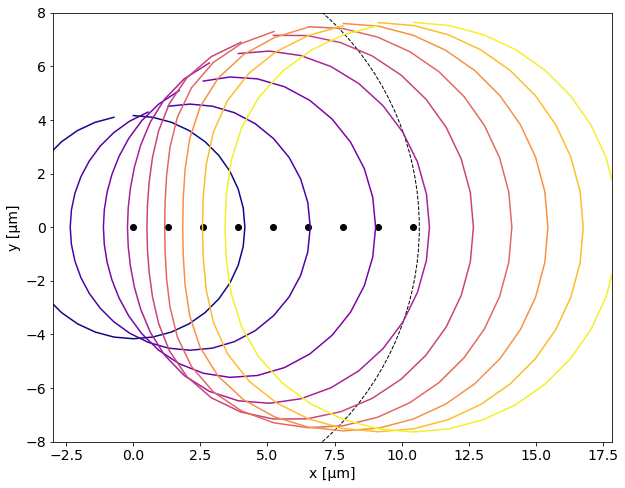

In [86]:
colorwave = cm.plasma(np.linspace(0, 1, Ntest))

fig=plt.figure(1, figsize = (9,7) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
value = 1.1*boundaryradius+startpoints[-1,2]
ax.set_xlim(-3,value)
ax.set_ylim(-8,8)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax.add_artist(circle2)
test = 6
for i in range(Ntest):
    if i % 6 == 0:
        plt.scatter(startpoints[i,0],0,color='k')
        plt.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i])
        
plt.tight_layout() 
plt.savefig('Ellipsiods.pdf', format='pdf')
plt.savefig('Ellipsiods.svg', format='svg')
plt.show()

In [87]:
sigma/pxtomum

50.0

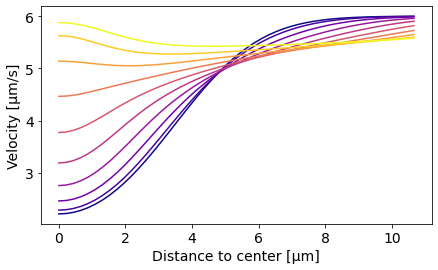

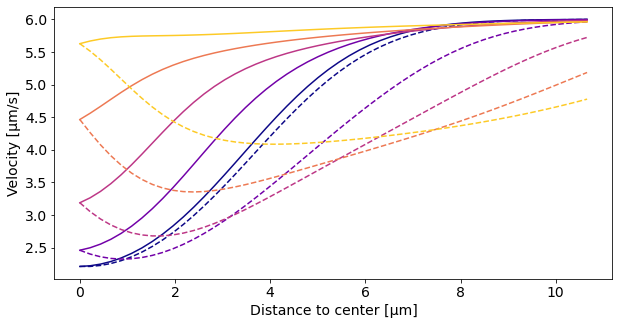

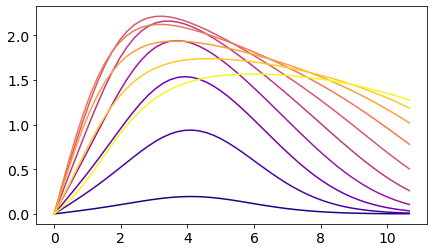

In [89]:
colorwave = cm.plasma(np.linspace(0, 1, number))
fig=plt.figure(1, figsize = (7,4) )
for i in range(number):
    delay = iterationtime*1e-3*(1+delayincrease*i-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2       
    plt.plot(rwave,vprofiles[i,:,0],color=colorwave[i],label = 'delay = '+str(round(delay,2))+'s')
plt.xlabel('Distance to center [µm]')
plt.ylabel('Velocity [µm/s]')
#plt.legend()
plt.savefig('V vs distance - with different velocity.pdf', format='pdf')
plt.savefig('V vs distance - with different velocity.svg', format='svg')
plt.show()

fig=plt.figure(1, figsize = (10,5) )
for i in range(number):
    if i % 2 == 0:
        delay = iterationtime*1e-3*(1+delayincrease*i-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2       
        plt.plot(rwave,vprofiles[i,:,1],color=colorwave[i],label = 'delay = '+str(round(delay,2))+'s')
        plt.plot(rwave,vprofiles[i,:,2],color=colorwave[i],linestyle='--',label = 'delay = '+str(round(delay,2))+'s')
plt.xlabel('Distance to center [µm]')
plt.ylabel('Velocity [µm/s]')
#plt.legend()
#plt.savefig('V vs distance - with different velocity.pdf', format='pdf')
plt.show()

fig=plt.figure(1, figsize = (7,4) )
for i in range(number):
        delay = iterationtime*1e-3*(1+delayincrease*i-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2       
        plt.plot(rwave,vprofiles[i,:,3],color=colorwave[i],label = 'delay = '+str(round(delay,2))+'s')
        #plt.plot(rwave,vprofiles[i,:,2],color=colorwave[i],linestyle='--',label = 'delay = '+str(round(delay,2))+'s')

plt.savefig('V difference.pdf', format='pdf')
plt.savefig('V difference.svg', format='svg')
plt.show()

(0.0, 10.66)

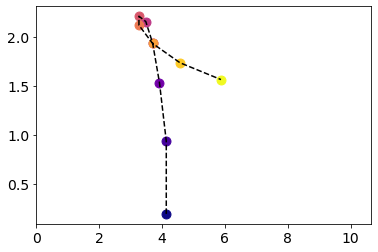

In [118]:
maxpoints = np.zeros((number,2))
for i in range(number):
    maxpoints[i,1] = max(vprofiles[i,:,3])
    check = np.argmax(vprofiles[i,:,3])
    maxpoints[i,0] = rwave[check]

colorwave = cm.plasma(np.linspace(0, 1, number))
for i in range(number):
    plt.scatter(maxpoints[i,0],maxpoints[i,1],s=80,color=colorwave[i])
plt.plot(maxpoints[:,0],maxpoints[:,1],color='k',linestyle='--',label = 'Simulation')
plt.xlim([0,boundaryradius])

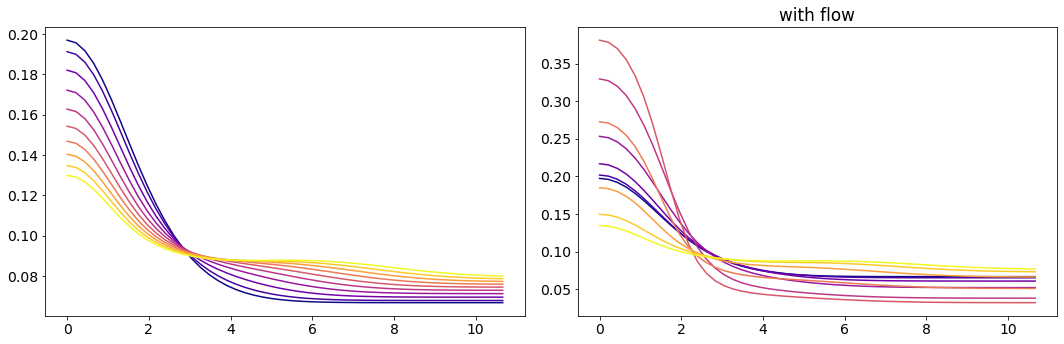

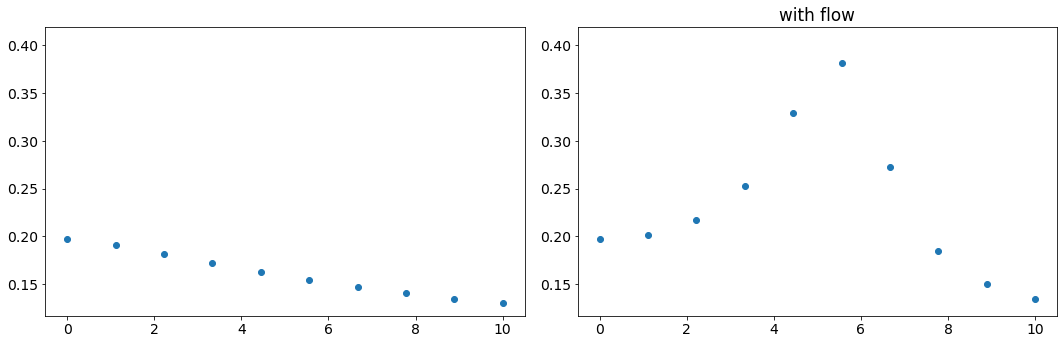

In [90]:
#dist, v, I = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
savedensity = np.zeros((Ntest,tlength))

for k in range(tlength):
    Darray = np.zeros(Ntest)
    Darray = savev[:,k,1]**2*taur/4# + D_0
    c = np.zeros(Ntest)        #array to save the density distributions
    c[0] = 1
    for i in range(0,Ntest-1):
        c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
        #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]+savev[i,k,2]**2*taur)))
        c[:] = c[:]/sum(abs(c[:])*dx)   #Normalize
    savedensity[:,k] = c

savedensity2 = np.zeros((Ntest,tlength))
for k in range(tlength):
    Darray = np.zeros(Ntest)
    Darray = savev[:,k,1]**2*taur/4# + D_0
    c = np.zeros(Ntest)        #array to save the density distributions
    c[0] = 1
    for i in range(0,Ntest-1):
        #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
        c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]-vprofiles[k,i,3]**2*taur)))
        c[:] = c[:]/sum(abs(c[:])*dx)   #Normalize
    savedensity2[:,k] = c
    
fig=plt.figure(1, figsize = (15,5) )
ax = plt.subplot(1,2,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savedensity[:,i],c=colorwave[i])
    
ax = plt.subplot(1,2,2)
plt.title('with flow')
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savedensity2[:,i],c=colorwave[i])
    
#ax.plot(r, vtheo,color='k',linestyle='--')
plt.tight_layout()  
#plt.savefig(str(title)+'.svg', format='svg')
plt.show()

maxi = 1.1*max(savedensity[0,0],max(savedensity2[0,:]))
mini = 0.9*min(savedensity[0,-1],savedensity2[0,-1])


fig=plt.figure(1, figsize = (15,5) )
ax = plt.subplot(1,2,1)
ax.scatter(np.linspace(0,tlength,tlength),savedensity[0,:])
ax.set_ylim([mini,maxi])
    
ax2 = plt.subplot(1,2,2)
plt.title('with flow')   
ax2.scatter(np.linspace(0,tlength,tlength),savedensity2[0,:])
ax2.set_ylim([mini,maxi])
    
plt.tight_layout()  
#plt.savefig(str(title)+'.svg', format='svg')
plt.show()

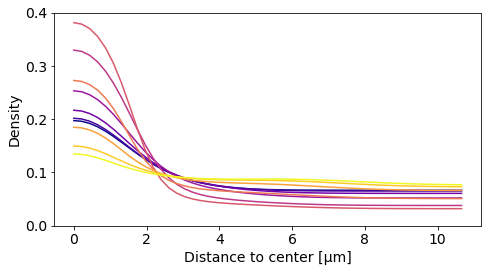

In [93]:
fig=plt.figure(1, figsize = (7,4) )
ax = plt.subplot(1,1,1)
colorwave = cm.plasma(np.linspace(0, 1, tlength))
for i in range(tlength):
    ax.plot(savev[:,i,0],savedensity2[:,i],c=colorwave[i])
    
plt.xlabel('Distance to center [µm]')
plt.ylabel('Density')
plt.ylim([0,0.4])
plt.tight_layout()  
plt.savefig('Density.pdf', format='pdf')
plt.savefig('Density.svg', format='svg')
plt.show()

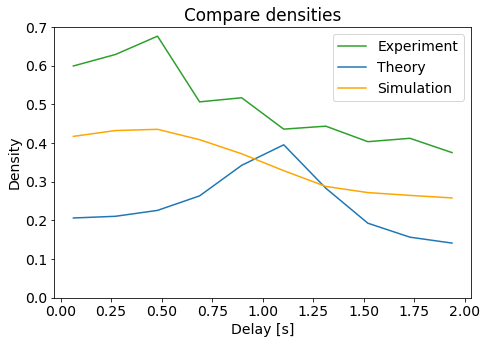

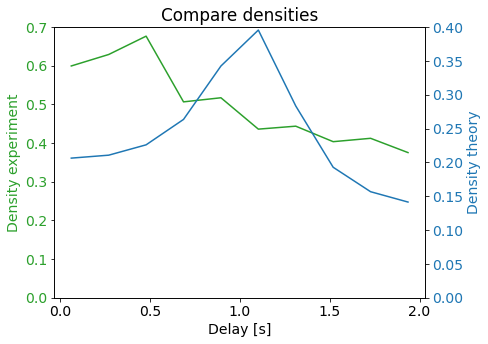

In [109]:
datadensity = [0.59937769, 0.6290357,  0.67642649, 0.50655708, 0.51715369, 0.43606253,
 0.44370338, 0.40363719, 0.41234334, 0.37542018]

simdensity = [0.41735623, 0.43239697, 0.43559092, 0.40881193, 0.37235399, 0.32867906,
 0.28788563, 0.27203268, 0.26476456, 0.25820109]

theodensity = np.zeros(tlength)
count = 0; check = True
while check == True:
    if savev[count,0,0] >= dataend: 
        check = False
        theoend = count
    else: count += 1
theodx = savev[1,0,0] - savev[0,0,0]
for i in range(tlength):
    theodensity[i] = sum(savedensity2[:theoend,i]*theodx)/sum(savedensity2[:,i]*theodx)

delaytime = np.zeros(tlength)
for i in range(tlength):
    delay = 1 + 4*i
    delaytime[i] = iterationtime*1e-3*(delay-1)+dt/2+addtime 

fig=plt.figure(1, figsize = (7,5) )
ax = plt.subplot(1,1,1)
color = 'tab:green'
ax.plot(delaytime,datadensity,color=color,label = 'Experiment')
color2 = 'tab:blue'
ax.plot(delaytime,theodensity,color=color2,label = 'Theory')
ax.plot(delaytime,simdensity,color='orange',label = 'Simulation')
ax.set_xlabel('Delay [s]')
ax.set_ylabel('Density')
ax.set_ylim([0,0.7])
plt.title('Compare densities')
plt.legend()
plt.tight_layout()  
plt.savefig('Compare Densities.pdf', format='pdf')
plt.savefig('Compare Densities.svg', format='svg')
plt.show()


fig=plt.figure(1, figsize = (7,5) )
ax = plt.subplot(1,1,1)
color = 'tab:green'
ax.plot(delaytime,datadensity,color=color,label = 'Experiment')
ax.set_xlabel('Delay [s]')
ax.set_ylabel('Density experiment',color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim([0,0.7])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:blue'
ax2.plot(delaytime,theodensity,color=color2,label = 'Theory')
ax2.set_ylabel('Density theory',color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([0,0.4])

plt.title('Compare densities')
plt.tight_layout()  
plt.savefig('Compare Densities 2.pdf', format='pdf')
plt.savefig('Compare Densities 2.svg', format='svg')
plt.show()

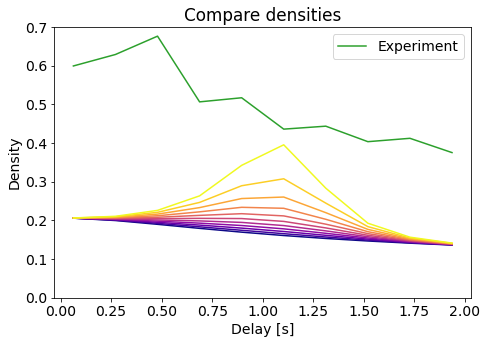

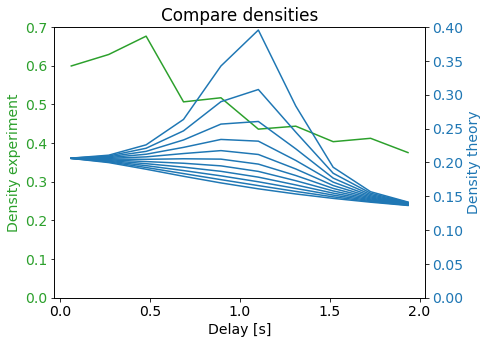

In [111]:
datadensity = [0.59937769, 0.6290357,  0.67642649, 0.50655708, 0.51715369, 0.43606253,
 0.44370338, 0.40363719, 0.41234334, 0.37542018]
#datax = [0.171875, 0.515625, 0.859375, 1.203125, 1.546875, 1.890625, 2.234375, 2.578125, 2.921875]
#dataend = (datax[3] + datax[2])/2 #mittel zwischen 2-3
#datadx = datax[1] - datax[0]

test = 11
theodensity = np.zeros((tlength,test))
for j in range(test):
    strength = j/10
    savedensity2 = np.zeros((Ntest,tlength))
    for k in range(tlength):
        Darray = np.zeros(Ntest)
        Darray = savev[:,k,1]**2*taur/4# + D_0
        c = np.zeros(Ntest)        #array to save the density distributions
        c[0] = 1
        for i in range(0,Ntest-1):
            #c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*Darray[i]))
            c[i+1] = c[i] * (1 - (Darray[i+1]-Darray[i]) / (2*(Darray[i]-strength*vprofiles[k,i,3]**2*taur)))
            c[:] = c[:]/sum(abs(c[:])*dx)   #Normalize
        savedensity2[:,k] = c
    
    count = 0; check = True
    while check == True:
        if savev[count,0,0] >= dataend: 
            check = False
            theoend = count
        else: count += 1
    theodx = savev[1,0,0] - savev[0,0,0]
    for i in range(tlength):
        theodensity[i,j] = sum(savedensity2[:theoend,i]*theodx)/sum(savedensity2[:,i]*theodx)

delaytime = np.zeros(tlength)
for i in range(tlength):
    delay = 1 + 4*i
    delaytime[i] = iterationtime*1e-3*(delay-1)+dt/2+addtime 

fig=plt.figure(1, figsize = (7,5) )
ax = plt.subplot(1,1,1)
color = 'tab:green'
ax.plot(delaytime,datadensity,color=color,label = 'Experiment')
colorwave = cm.plasma(np.linspace(0, 1, test))
for i in range(test):
    ax.plot(delaytime,theodensity[:,i],color=colorwave[i])#,label = str(0.1*i))
ax.set_xlabel('Delay [s]')
ax.set_ylabel('Density')
ax.set_ylim([0,0.7])
plt.title('Compare densities')
plt.legend()
plt.tight_layout()  
plt.savefig('Compare Densities new.pdf', format='pdf')
plt.savefig('Compare Densities new.svg', format='svg')
plt.show()


fig=plt.figure(1, figsize = (7,5) )
ax = plt.subplot(1,1,1)
color = 'tab:green'
ax.plot(delaytime,datadensity,color=color,label = 'Experiment')
ax.set_xlabel('Delay [s]')
ax.set_ylabel('Density experiment',color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim([0,0.7])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:blue'
ax2.plot(delaytime,theodensity,color=color2,label = 'Theory')
ax2.set_ylabel('Density theory',color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([0,0.4])

plt.title('Compare densities')
plt.tight_layout()  
plt.savefig('Compare Densities 2 new.pdf', format='pdf')
plt.savefig('Compare Densities 2 new.svg', format='svg')
plt.show()

In [104]:
theodensity[1,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21070244,
       0.        ])

<ipython-input-4-7f85373cda4a>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(x,y,field[:,:,3])


NameError: name 'importantsteps' is not defined

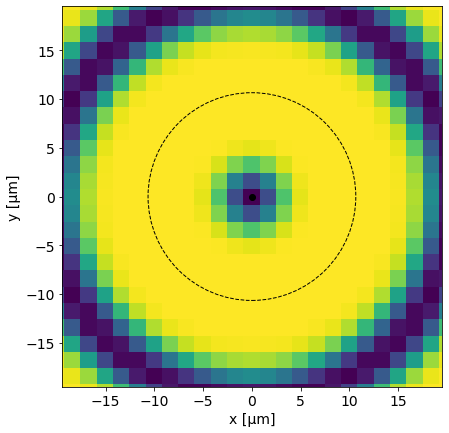

In [4]:
Nx = 51
steps = boundaryradius*8/Nx
field = np.zeros((Nx,Nx,4))

for i in range(Nx):          #Create v field - just for drawing
    field[:,i,0] = np.linspace(-4*boundaryradius,4*boundaryradius,Nx)
    field[i,:,1] = np.linspace(-4*boundaryradius,4*boundaryradius,Nx)
for i in range(Nx):
    for j in range(Nx):
        field[i,j,2] = np.sqrt(pow(field[i,j,0],2)+pow(field[i,j,1],2))
        if field[i,j,2] <= boundaryradius:
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin
        else: 
            field[i,j,2] = 2*boundaryradius - field[i,j,2] 
            I = amplitude*np.exp(-field[i,j,2]**2/sigmaterm)
            field[i,j,3] = vactive*vdiff*np.exp(-I/amplitude)+vmin

fig=plt.figure(1, figsize = (15,7) )
ax = plt.subplot(1,2,1)
ax.set_aspect('equal')
y, x = np.mgrid[slice(-4*boundaryradius, 4*boundaryradius, steps),
                slice(-4*boundaryradius, 4*boundaryradius, steps)]
im = ax.pcolor(x,y,field[:,:,3])
value = 2*boundaryradius+startpoints[-1,2]
ax.set_xlim(-value,value)
ax.set_ylim(-value,value)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

colorwave = cm.plasma(np.linspace(0, 1, Ntest))
circle2 = plt.Circle((0, 0), boundaryradius, color='k',linestyle='--', fill=False)
ax.add_artist(circle2)
for i in range(Ntest):
    if i % 6 == 0:
        plt.scatter(startpoints[i,0],0,color='k')
        plt.plot(importantsteps[test,i,:,1],importantsteps[test,i,:,0],c=colorwave[i]) 
cb = fig.colorbar(im, ax=ax)
cb.set_label(r'$v$ [µm/s]')

size = 100
pltarray = np.zeros((100,3))
pltarray[:,0] = np.linspace(0,2*boundaryradius,size)
for i in range(size):
    dist1 = pltarray[i,0]
    dist2 = pltarray[i,0]
    if pltarray[i,0] >= boundaryradius:
        dist1 = 2*boundaryradius - pltarray[i,0]
        dist2 = 2*boundaryradius - 0.5*pltarray[i,0]
    I1 = amplitude*np.exp(-dist1**2/sigmaterm)
    pltarray[i,1] = vactive*vdiff*np.exp(-I1/amplitude)+vmin
    I2 = amplitude*np.exp(-dist2**2/sigmaterm)
    pltarray[i,2] = vactive*vdiff*np.exp(-I2/amplitude)+vmin
    
ax2 = plt.subplot(1,2,2)
ax2.plot(pltarray[:,0],pltarray[:,1],label='mirrored')
ax2.plot(pltarray[:,0],pltarray[:,2],label='elongated')
plt.xlabel('Distance to center [µm]')
plt.ylabel('Velocity [µm/s]')
plt.legend()


plt.savefig('Fig1.pdf', format='pdf')
plt.savefig('Fig1.svg', format='svg')
plt.show()

In [22]:
pltarray[:,1]

array([2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727665,
       2.20727665, 2.20727665, 2.20727665, 2.20727665, 2.20727